# Loading data

In [1]:
import numpy as np
import hicstraw

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [3]:
# hic = hicstraw.HiCFile("https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic")

In [4]:
hic = hicstraw.HiCFile("GSM1551688_HIC143.hic")

In [5]:
hic.getGenomeID()

'hg19'

In [6]:
hic.getResolutions()

[2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000]

In [7]:
for chrom in hic.getChromosomes():
    print(chrom.name, chrom.length)

All 3098789
1 249250621
2 243199373
3 198022430
4 191154276
5 180915260
6 171115067
7 159138663
8 146364022
9 141213431
10 135534747
11 135006516
12 133851895
13 115169878
14 107349540
15 102531392
16 90354753
17 81195210
18 78077248
19 59128983
20 63025520
21 48129895
22 51304566
X 155270560
Y 59373566
MT 16569


In [8]:
mzd = hic.getMatrixZoomData(
    "4", "4", "observed", "KR", "BP", 50000
)  # for those smaller files "KR" doesnt work

In [9]:
numpy_matrix_chr4 = mzd.getRecordsAsMatrix(0, 2000000, 0, 2000000)

In [10]:
numpy_matrix_chr4

array([[15.57630444,  2.69259524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.69259524, 24.43638992,  1.25475776, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.25475776, 16.67105484, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 14.22935486,
         0.        ,  2.89050484],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        14.14781857,  1.89398408],
       [ 0.        ,  0.        ,  0.        , ...,  2.89050484,
         1.89398408, 11.15618801]])

In [11]:
numpy_matrix_chr4.shape

(41, 41)

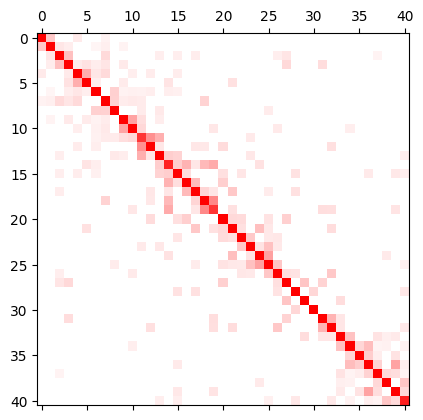

In [12]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])


# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor):
    plt.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    plt.show()


plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2)

In [13]:
import juicebox_notebook

In [14]:
juicebox_notebook.init()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
b = juicebox_notebook.Browser(
    {  # load hic via URL
        "name": "GM12878",
        "locus": "2:3,319,567-30,009,566",
        "url": "https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic",
        "normalization": "KR",
    }
)

<IPython.core.display.Javascript object>

# Arrowhead

In [16]:
# java -jar juicer_tools_1.22.01.jar arrowhead <options, eg: > -k NONE -r 5000 hic_data/inter_30.hic test --ignore-sparsity

## Links

[Main juicer repo (git clone)](https://github.com/aidenlab/juicer)   
[Arrowhead jar download](https://github.com/aidenlab/juicer/wiki/Download)   
[Arrowhead use instruction](https://github.com/aidenlab/juicer/wiki/Arrowhead)  

# Algorithm

In [17]:
import networkx as nx
import numpy as np
import pandas as pd

In [18]:
import random
import copy


class ModLouvien:
    def __init__(self, A, gamma, eps=1e-10, seed=None):
        self.A = A
        self.gamma = gamma
        self.classes = [
            i for i in range(len(A))
        ]  # communities assignments, at first -- each node to different community
        self.eps = eps  # for stopping condition
        self.communities = [[i] for i in range(len(self.classes))]  # final communities
        if seed:
            random.seed(seed)

    def run_algorithm(self, verbose=False):
        # main algorithm function, implements version from https://www.biorxiv.org/content/10.1101/089011v1.full
        A, classes = self.A, self.classes
        rowsum = A.sum().to_numpy()[np.newaxis]
        rowcolsums = pd.DataFrame(
            np.matmul(rowsum.T, rowsum)
        )  # matrix witk k_ik_j, for speeding up Q computation
        Q_prev = -1
        Q_curr = self.compute_Q(A, classes, rowcolsums)
        while Q_curr - Q_prev > self.eps:
            Q_prev = Q_curr
            rand_idx = list(
                range(len(classes))
            )  # We permute indexes randomly each time
            random.shuffle(rand_idx)
            for i in rand_idx:
                # switching left/right neighbour and comparing if Q increased
                i_left = max(0, i - 1)
                i_right = min(len(rand_idx) - 1, i + 1)

                classes_left = copy.copy(classes)
                classes_left[i_left] = classes_left[i]
                classes_right = copy.copy(classes)
                classes_right[i_right] = classes_right[i]

                Q_left = self.compute_Q(A, classes_left, rowcolsums)
                Q_right = self.compute_Q(A, classes_right, rowcolsums)
                Q_max = max(Q_curr, Q_left, Q_right)
                if Q_max == Q_left:
                    classes = classes_left
                    Q_curr = Q_left
                if Q_max == Q_right:
                    classes = classes_right
                    Q_curr = Q_right

            A, classes, rowcolsums = self.consolidate_communities(A, classes)
            if len(classes) <= 1:
                break
            if verbose:
                print(f"Current Q: {Q_curr}")
                print(f"Prev Q: {Q_prev}")
        return self.communities

    def consolidate_communities(self, A, classes):
        # Communities consolidation - we recalculate A and classes so that we get A and classes for new communities
        new_classes = []
        indices = []
        curr_indices = []
        # creating new_classes
        for i in range(1, len(classes)):
            curr_indices.append(i - 1)
            eq = True
            if classes[i - 1] != classes[i]:
                eq = False
                new_classes.append(classes[i - 1])
                indices.append(curr_indices)
                curr_indices = []
        # checking if the last element was not same as next-to last
        if not eq:
            indices.append([len(classes) - 1])
            new_classes.append(len(classes) - 1)
        else:
            indices[-1].append(len(classes) - 1)

        new_A = pd.DataFrame(np.zeros((len(new_classes), len(new_classes))))
        for i in range(len(indices)):
            for j in range(len(indices)):
                for k in indices[i]:
                    for l in indices[j]:
                        new_A.iloc[i, j] += A.iloc[k, l]
        rowsum = new_A.sum().to_numpy()[np.newaxis]
        rowcolsums = pd.DataFrame(np.matmul(rowsum.T, rowsum))
        self.update_global_communities(indices)
        return new_A, new_classes, rowcolsums

    def update_global_communities(self, indices):
        # updating global communities assignments
        new_communities = [[] for _ in range(len(indices))]
        for i in range(len(indices)):
            for j in indices[i]:
                new_communities[i] += self.communities[j]

        self.communities = new_communities

    def compute_Q(self, A, classes, rowcolsums):
        # Q computation from the formula from article -- using numpy einsum for faster computation
        Q = 0
        m = A.to_numpy().sum()
        delta = np.equal.outer(classes, classes)
        Q = np.sum((A.values - self.gamma * rowcolsums.values / m) * delta)
        return Q / m

In [19]:
lv = ModLouvien(pd.DataFrame(numpy_matrix_chr4), 1.5)

In [20]:
communities = lv.run_algorithm(verbose=True)

Current Q: 0.6283734926508576
Prev Q: 0.5556543985650151
Current Q: 0.647205282006555
Prev Q: 0.6283734926508576
Current Q: 0.647205282006555
Prev Q: 0.647205282006555


In [21]:
communities

[[0, 1],
 [2, 3],
 [4, 5],
 [6, 7, 8],
 [9, 10],
 [11, 12, 13],
 [14, 15, 16, 17, 18, 19],
 [20, 21],
 [22, 23, 24, 25],
 [26, 27, 28],
 [29],
 [30],
 [31, 32, 33],
 [34, 35, 36, 37],
 [38, 40]]

In [22]:
%%timeit
ModLouvien(pd.DataFrame(numpy_matrix_chr4), 1.5).run_algorithm(verbose=False)

107 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
